In [2]:
import os
import pandas as pd
import numpy as np

# Base path to your dataset
base_path = os.path.join("data", "UCI")

# STEP 1: Load and clean feature names
features = pd.read_csv(
    os.path.join(base_path, "features.txt"),
    sep="\s+", header=None, names=["index", "feature_name"]
)

# Force unique column names by appending an index if duplicate exists
from collections import defaultdict

feature_count = defaultdict(int)
unique_feature_names = []

for name in features["feature_name"]:
    name = name.strip()
    feature_count[name] += 1
    if feature_count[name] == 1:
        unique_feature_names.append(name)
    else:
        unique_feature_names.append(f"{name}_{feature_count[name]}")

# STEP 2: Load activity labels
activity_labels = pd.read_csv(
    os.path.join(base_path, "activity_labels.txt"),
    sep="\s+", header=None, names=["id", "activity"]
)
activity_map = dict(zip(activity_labels["id"], activity_labels["activity"]))

# STEP 3: Load training data
X_train = pd.read_csv(
    os.path.join(base_path, "train", "X_train.txt"),
    sep="\s+", header=None, names=unique_feature_names
)

y_train = pd.read_csv(
    os.path.join(base_path, "train", "y_train.txt"),
    header=None, names=["Activity"]
)

subject_train = pd.read_csv(
    os.path.join(base_path, "train", "subject_train.txt"),
    header=None, names=["Subject"]
)

# STEP 4: Combine into one DataFrame
train_df = pd.concat([subject_train, y_train, X_train], axis=1)
train_df["ActivityName"] = train_df["Activity"].map(activity_map)

# STEP 5: Preview
print("✅ Data imported successfully!")
print("📐 Shape of training data:", train_df.shape)
print("🎯 Sample activity labels:", train_df['ActivityName'].unique())
print("👥 Unique subjects:", train_df['Subject'].nunique())
train_df.head()


✅ Data imported successfully!
📐 Shape of training data: (7352, 564)
🎯 Sample activity labels: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
👥 Unique subjects: 21


,Subject,Activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",ActivityName
0,1,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,1,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,1,5,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,1,5,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


🔁 Highly correlated features (>0.95): 308
📉 Low variance features (<0.01): 37


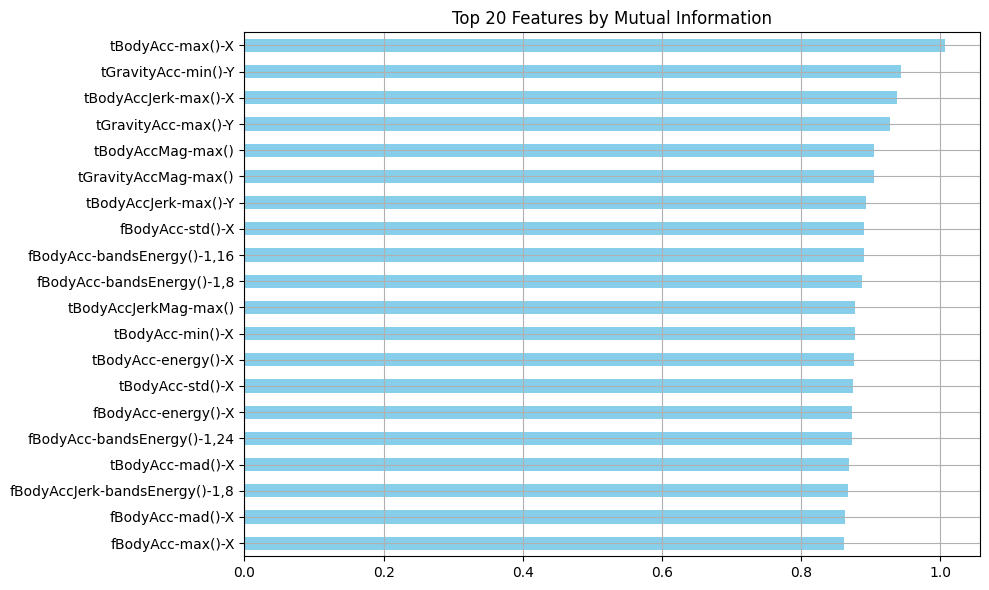

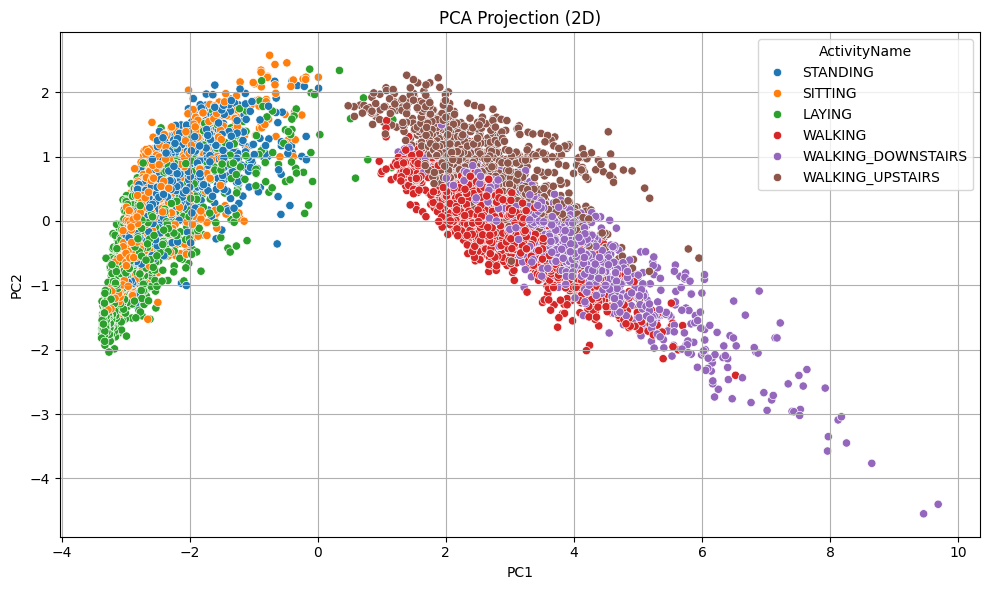

In [3]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 6: Prepare X and y
X = train_df.drop(columns=["Subject", "Activity", "ActivityName"])
y = train_df["Activity"]

# STEP 7: Correlation Matrix (remove highly correlated features > 0.95)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]
print(f"🔁 Highly correlated features (>0.95): {len(high_corr_features)}")

# STEP 8: Variance Threshold (remove low variance features)
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(X)
low_variance_features = X.columns[~var_thresh.get_support()]
print(f"📉 Low variance features (<0.01): {len(low_variance_features)}")

# STEP 9: Mutual Information Feature Selection
mi_selector = SelectKBest(mutual_info_classif, k=20)
mi_selector.fit(X, y)
mi_scores = pd.Series(mi_selector.scores_, index=X.columns).sort_values(ascending=False)

# Visualize top 20 mutual information scores
plt.figure(figsize=(10, 6))
mi_scores.head(20).plot(kind='barh', color='skyblue')
plt.title("Top 20 Features by Mutual Information")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 10: PCA for Dimensionality Reduction
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["ActivityName"] = train_df["ActivityName"]

# Visualize PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="ActivityName", palette="tab10")
plt.title("PCA Projection (2D)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

# STEP 1: Drop highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]

# STEP 2: Drop low variance features
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(X)
low_variance_features = X.columns[~var_thresh.get_support()]

# STEP 3: Combine dropped features
features_to_drop = list(set(high_corr_features).union(set(low_variance_features)))
X_cleaned = X.drop(columns=features_to_drop)

# STEP 4: Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_cleaned)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_cleaned.columns)

# STEP 5: Encode labels (for classification)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df["Activity"])

# STEP 6: Build final DataFrame
prepared_df = pd.concat([
    train_df[["Subject"]].reset_index(drop=True),
    pd.DataFrame({"Activity": y_encoded}),
    X_normalized_df
], axis=1)

# Optional: map activity names back in a readable column
prepared_df["ActivityName"] = label_encoder.inverse_transform(y_encoded)

# ✅ Preview
print("📦 Prepared data sample:")
display(prepared_df.head(20))  # works best in Jupyter


📦 Prepared data sample:


,Subject,Activity,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-max()-Z,tBodyAcc-min()-Z,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-entropy()-X,...,fBodyBodyGyroMag-skewness(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)",ActivityName
0,1,4,-0.868814,-0.939441,-0.737529,-0.637379,0.738383,-0.775696,-0.670496,-0.649898,...,2.571343,-0.616153,-0.706661,-0.795359,0.025960,-0.360603,0.062940,-0.778427,-0.026080,5
1,1,4,-0.875426,-0.923902,-0.849304,-0.889197,0.766503,-0.775105,-0.687585,-1.304893,...,-0.253097,-0.633698,-0.706661,0.130614,-0.897357,0.133011,-0.021461,-1.218805,1.484470,5
2,1,4,-0.869039,-0.907760,-0.893785,-0.889197,0.822606,-0.774088,-0.692379,-1.043324,...,-0.862529,-0.641077,2.398628,1.152336,-0.260878,-0.377840,0.391976,0.151207,1.704201,5
3,1,4,-0.870626,-0.940022,-0.921805,-0.927662,0.817653,-0.774691,-0.692533,-1.118413,...,0.072130,-0.640381,-0.263048,1.112769,0.591045,-0.135025,-0.033637,1.037851,-1.003019,5
4,1,4,-0.875188,-0.934878,-0.921343,-0.910626,0.817653,-0.775640,-0.693672,-1.457712,...,-0.785768,-0.649103,-0.263048,-0.149577,-0.138515,0.340406,0.268486,1.125918,-1.276282,5
5,1,4,-0.873397,-0.954117,-0.933139,-0.904026,0.844693,-0.775649,-0.694396,-1.383748,...,-0.282901,-0.654800,-0.706661,-0.419721,-0.742707,0.219586,-0.324856,0.437830,-0.757922,5
6,1,4,-0.872474,-0.907757,-0.903754,-0.885047,0.803288,-0.774076,-0.693119,-1.139181,...,-0.208028,-0.646600,-0.706661,0.081880,0.279795,-0.657546,-0.519341,0.009718,-0.384001,5
7,1,4,-0.871668,-0.906847,-0.900094,-0.885047,0.799231,-0.771564,-0.691001,-1.130767,...,-0.470407,-0.646974,-0.706661,0.044181,0.700031,-0.087811,1.320191,-0.938078,0.990421,5
8,1,4,-0.873382,-0.895938,-0.905077,-0.906615,0.799231,-0.773043,-0.692183,-1.237133,...,-0.360501,-0.629394,-0.706661,0.752040,0.117163,0.012681,0.175674,-0.399562,0.258981,5
9,1,4,-0.867755,-0.918844,-0.911221,-0.880491,0.819621,-0.774103,-0.693498,-0.954795,...,1.103588,-0.584233,-0.706661,0.566145,2.014197,-0.086925,-0.289813,-0.808199,-0.135349,5


In [6]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report
import pandas as pd
import numpy as np

# STEP 1: Extract data from prepared_df
X_full = prepared_df.drop(columns=["Subject", "ActivityName", "Activity"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]

# STEP 2: Set up Leave-One-Subject-Out cross-validation
logo = LeaveOneGroupOut()

# Storage for results
fold_accuracies = []
fold_losses = []
fold_reports = []

# STEP 3: Train and evaluate for each subject
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
    y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]
    
    # Logistic Regression with cross-entropy loss
    model = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    fold_accuracies.append(acc)
    fold_losses.append(loss)
    fold_reports.append(report)

# STEP 4: Summarize results per subject
results_df = pd.DataFrame({
    "Subject": sorted(prepared_df["Subject"].unique()),
    "Accuracy": fold_accuracies,
    "CrossEntropyLoss": fold_losses
})
results_df["FoldIndex"] = results_df.index + 1
results_df = results_df[["FoldIndex", "Subject", "Accuracy", "CrossEntropyLoss"]]

# STEP 5: Display
print("📊 LOSO Cross-Validation Results (Logistic Regression):")
display(results_df)


c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' 

📊 LOSO Cross-Validation Results (Logistic Regression):


,FoldIndex,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.018495
1,2,3,0.970674,0.088538
2,3,5,0.890728,0.501391
3,4,6,0.870769,0.615488
4,5,7,0.873377,0.440295
5,6,8,0.967972,0.076522
6,7,11,0.984177,0.047857
7,8,14,0.715170,1.840626
8,9,15,0.987805,0.056035
9,10,16,0.775956,0.815281


0        1
1        1
2        1
3        1
4        1
        ..
7347    30
7348    30
7349    30
7350    30
7351    30
Name: Subject, Length: 7352, dtype: int64
kkkkkkk
0       4
1       4
2       4
3       4
4       4
       ..
7347    1
7348    1
7349    1
7350    1
7351    1
Name: Activity, Length: 7352, dtype: int64
yooooooooooo
      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-max()-Z  \
0            -0.868814         -0.939441         -0.737529         -0.637379   
1            -0.875426         -0.923902         -0.849304         -0.889197   
2            -0.869039         -0.907760         -0.893785         -0.889197   
3            -0.870626         -0.940022         -0.921805         -0.927662   
4            -0.875188         -0.934878         -0.921343         -0.910626   
...                ...               ...               ...               ...   
7347          0.913859          1.095963          1.628612          1.634933   
7348          0.824887 

c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 1 (Subject 1):
  Accuracy           = 0.9914 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0185 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 2 (Subject 3):
  Accuracy           = 0.9707 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0885 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 3 (Subject 5):
  Accuracy           = 0.8907 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.5014 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 4 (Subject 6):
  Accuracy           = 0.8708 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.6155 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 5 (Subject 7):
  Accuracy           = 0.8734 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.4403 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 6 (Subject 8):
  Accuracy           = 0.9680 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0765 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 7 (Subject 11):
  Accuracy           = 0.9842 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0479 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklea

Fold 8 (Subject 14):
  Accuracy           = 0.7152 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.8406 -> Lower loss indicates more reliable probability estimates.

Fold 9 (Subject 15):
  Accuracy           = 0.9878 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0560 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 10 (Subject 16):
  Accuracy           = 0.7760 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.8153 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 11 (Subject 17):
  Accuracy           = 0.9783 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0566 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 12 (Subject 19):
  Accuracy           = 0.9194 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1930 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 13 (Subject 21):
  Accuracy           = 0.9363 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2074 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 14 (Subject 22):
  Accuracy           = 0.9720 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0649 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 15 (Subject 23):
  Accuracy           = 0.9812 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0585 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 16 (Subject 25):
  Accuracy           = 0.9462 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1648 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 17 (Subject 26):
  Accuracy           = 0.9719 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0726 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 18 (Subject 27):
  Accuracy           = 0.9894 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0343 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 19 (Subject 28):
  Accuracy           = 0.9031 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.3709 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 20 (Subject 29):
  Accuracy           = 0.9593 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1171 -> Lower loss indicates more reliable probability estimates.



c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 21 (Subject 30):
  Accuracy           = 0.9843 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0374 -> Lower loss indicates more reliable probability estimates.

Overall LOSO-CV Results (Logistic Regression):


,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.018495
1,2,3,0.970674,0.088538
2,3,5,0.890728,0.501391
3,4,6,0.870769,0.615488
4,5,7,0.873377,0.440295
5,6,8,0.967972,0.076522
6,7,11,0.984177,0.047857
7,8,14,0.715170,1.840626
8,9,15,0.987805,0.056035
9,10,16,0.775956,0.815281



Average Accuracy: 0.9319
Average Cross-Entropy Loss: 0.2799


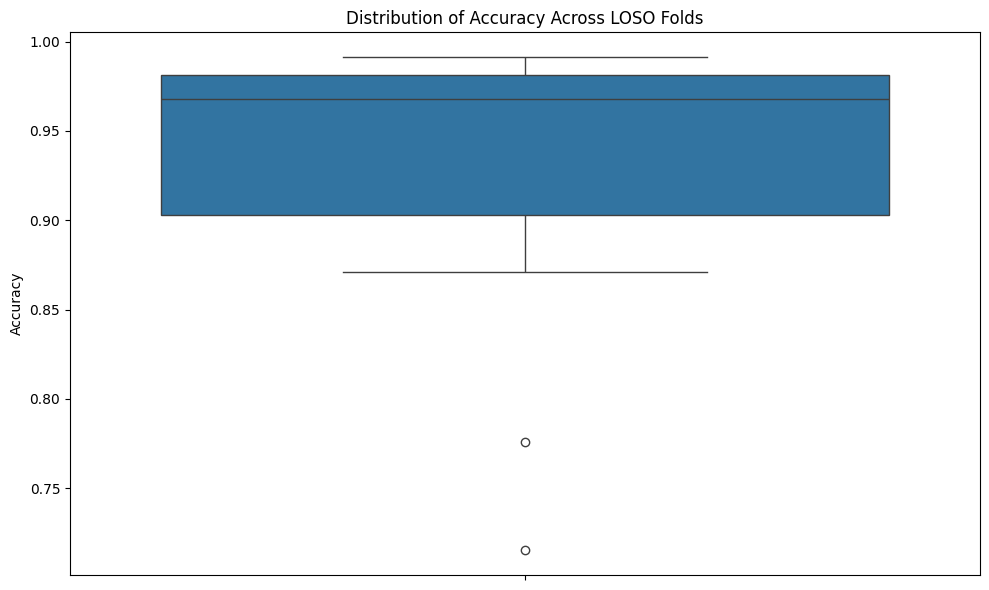

c:\Users\MSI\.conda\envs\aura1\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Testing on 3 Random Samples:
Sample 1 (Index 5961):
  True Activity     : 6
  Predicted Activity: 6
----------------------------------------
Sample 2 (Index 1433):
  True Activity     : 3
  Predicted Activity: 3
----------------------------------------
Sample 3 (Index 5456):
  True Activity     : 2
  Predicted Activity: 2
----------------------------------------


In [16]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# BLO4: LOSO-CV Training & Evaluation for Logistic Regression
# ==========================================

# STEP 1: Extract data from prepared_df
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]
print(groups)
print("kkkkkkk")
print(y_full)
print("yooooooooooo")
print(X_full)

# STEP 2: Set up Leave-One-Subject-Out CV
logo = LeaveOneGroupOut()

# Containers to store metrics for each fold
fold_accuracies = []
fold_losses = []
fold_reports = []
fold_subjects = []  # to record which subject is held out

print("Starting Leave-One-Subject-Out Cross-Validation (LOSO-CV):\n")

# STEP 3: Iterate over each subject (fold)
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    # Get held-out subject ID (all entries in test_idx have the same Subject)
    test_subject = groups.iloc[test_idx].unique()[0]
    fold_subjects.append(test_subject)
    
    # Split data for this fold
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    # Train Logistic Regression (multinomial uses cross-entropy loss)
    model = LogisticRegression(max_iter=300, multi_class='multinomial', solver='lbfgs', random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the held-out subject's data
    y_pred = model.predict(X_test_fold)
    y_proba = model.predict_proba(X_test_fold)
    
    # Calculate metrics for this fold
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    
    fold_accuracies.append(acc)
    fold_losses.append(ce_loss)
    fold_reports.append(report)
    
    # Print per-fold results with explanation
    print(f"Fold {fold+1} (Subject {test_subject}):")
    print(f"  Accuracy           = {acc:.4f} -> Percentage of correct predictions for this subject.")
    print(f"  Cross-Entropy Loss = {ce_loss:.4f} -> Lower loss indicates more reliable probability estimates.\n")

# STEP 4: Summarize LOSO results in a DataFrame
results_df = pd.DataFrame({
    "Fold": list(range(1, len(fold_accuracies)+1)),
    "Subject": fold_subjects,
    "Accuracy": fold_accuracies,
    "CrossEntropyLoss": fold_losses
})
print("Overall LOSO-CV Results (Logistic Regression):")
display(results_df)
print("\nAverage Accuracy: {:.4f}".format(np.mean(fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(fold_losses)))

# Plot distribution of accuracies across folds
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, y="Accuracy")
plt.title("Distribution of Accuracy Across LOSO Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ==========================================
# BLO4 - Part 2: Additional Testing on Random Samples
# ==========================================
# Now, to check predictions on unseen testing samples:
# Train a final model on the entire prepared data.
final_model = LogisticRegression(max_iter=300, multi_class='multinomial', solver='lbfgs', random_state=42)
final_model.fit(X_full, y_full)

# Randomly select 3 samples from the entire dataset (for demonstration)
random_indices = np.random.choice(X_full.index, size=3, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]

# Generate predictions for these samples
predicted_labels = final_model.predict(test_samples)

# Convert numeric labels to activity names using the label encoder
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)

# Print predicted vs. true activities for each sample
print("\nTesting on 3 Random Samples:")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_activities[i]}")
    print(f"  Predicted Activity: {predicted_activities[i]}")
    print("-" * 40)
